# Project fruit
The goal of this project is classifying fruits and determining its ripeness

In [91]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import datetime
import keras
import os
# import pandas as pd
# import seaborn as sns
# from keras.models import load_model
from keras.models import Sequential 
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img

# Use GPU (needed?)
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

physical_devices = tf.config.experimental.list_physical_devices('GPU')
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, True)

# Loads Tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [92]:
# Clear any logs from previous runs
!rm -rf ./logs/

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [93]:
train_path_360 = 'C:/Users/emanu/Documents/Programming/Python/Project/ADL/data/fruits-360_mod/Training'
test_path_360 = 'C:/Users/emanu/Documents/Programming/Python/Project/ADL/data/fruits-360_mod/Test'

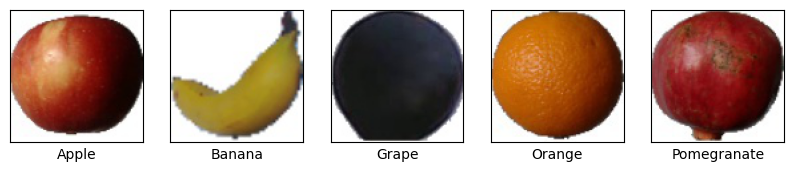

In [94]:
# Insert fruits that you want to inspect
fruits = ['Apple', 'Banana', 'Grape', 'Orange', 'Pomegranate']
# Which image in the folder
fruitnr = 1

plt.figure(figsize=(10,10))
for i in range(len(fruits)):    
    img = load_img(train_path_360 + "/{fruit:}/{filename:}".format(fruit=fruits[i], filename=os.listdir(train_path_360 + '/' + fruits[i])[fruitnr-1]))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.xlabel(fruits[i])
plt.show()

In [95]:
img = img_to_array(img)
img.shape

(100, 100, 3)

In [96]:
img_height, img_width, channels = 100, 100, 3

VGG16 = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(img_height,img_width,channels))

# Get the list of subdirectories
subdirectories = [f.path for f in os.scandir(train_path_360) if f.is_dir()]

# Count the number of subdirectories
num_classes = len(subdirectories)

model = Sequential()

model.add(VGG16)

# Lower dropout rate?
model.add(Flatten())
model.add(Dense(3*384, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(3*128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 4608)              0         
                                                                 
 dense_12 (Dense)            (None, 1152)              5309568   
                                                                 
 dropout_8 (Dropout)         (None, 1152)              0         
                                                                 
 dense_13 (Dense)            (None, 384)               442752    
                                                                 
 dropout_9 (Dropout)         (None, 384)               0         
                                                                 
 dense_14 (Dense)            (None, 5)                

In [97]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss="categorical_crossentropy",
              optimizer = optimizer,
              metrics = ["Accuracy", "Recall", "Precision"])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [98]:
# Choose transformations
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    fill_mode='constant',
                    cval=255,
                    shear_range=0.3,
                    rotation_range=180,
                    zoom_range=[1, 2],
                    validation_split=0.2
                    )

test_datagen  = ImageDataGenerator(rescale = 1./255)

# Kind of like DataLoader
train_generator = train_datagen.flow_from_directory(train_path_360,
                                                    target_size = (100,100),
                                                    batch_size = 32,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training")
validation_generator = train_datagen.flow_from_directory(train_path_360,
                                                    target_size = (100, 100),
                                                    batch_size = 32,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "validation")
test_generator = test_datagen.flow_from_directory(test_path_360,
                                                    target_size = (100,100),
                                                    batch_size = 32,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical")

Found 8908 images belonging to 5 classes.
Found 2225 images belonging to 5 classes.
Found 3659 images belonging to 5 classes.


c:\Users\emanu\anaconda3\envs\adl\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


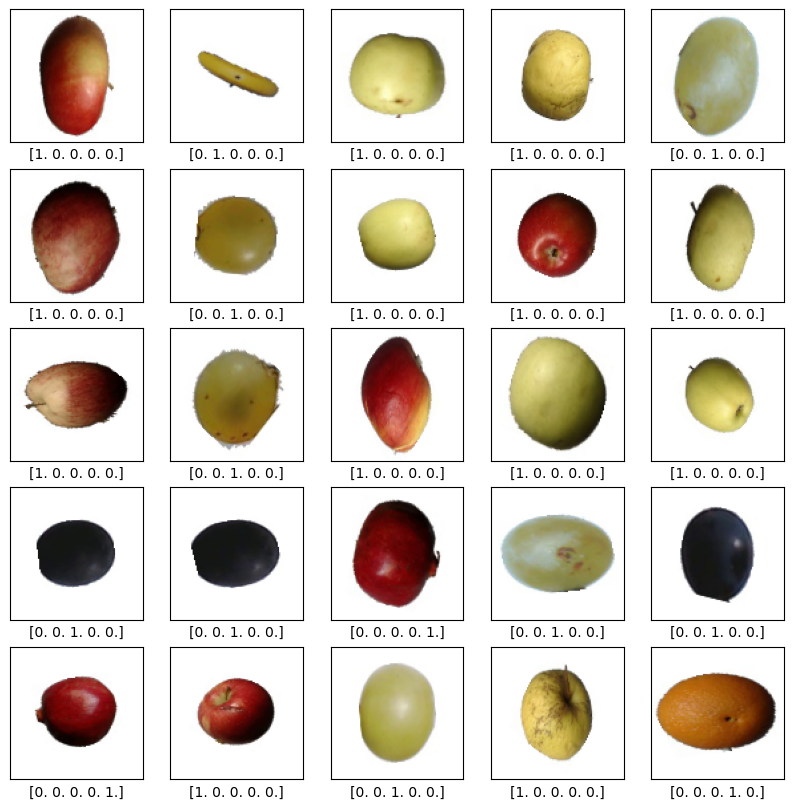

In [99]:
# Generate a batch of augmented images
augmented_images, labels = train_generator.next()

# Limit the number of images to display
num_images = min(augmented_images.shape[0], 25)

# Plot the augmented images
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(augmented_images[i])
    plt.xlabel(labels[i])
plt.show()

In [100]:
# Place to save the model weights
checkpoint_path = "C:/Users/emanu/Documents/Programming/Python/Project/ADL/models/model_360.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 save_best_only=True,
                                                 verbose=1)

In [101]:
hist = model.fit(train_generator,
                 epochs = 10,
                 validation_data = validation_generator,
                 callbacks=[tensorboard_callback, cp_callback])

Epoch 1/10
279/279 [==============================] - ETA: 0s - loss: 0.9806 - Accuracy: 0.6505 - recall: 0.5395 - precision: 0.6747
Epoch 1: val_loss improved from inf to 1.21929, saving model to C:/Users/emanu/Documents/Programming/Python/Project/ADL/models\model_360.ckpt


INFO:tensorflow:Assets written to: C:/Users/emanu/Documents/Programming/Python/Project/ADL/models\model_360.ckpt\assets


INFO:tensorflow:Assets written to: C:/Users/emanu/Documents/Programming/Python/Project/ADL/models\model_360.ckpt\assets


279/279 [==============================] - 499s 2s/step - loss: 0.9806 - Accuracy: 0.6505 - recall: 0.5395 - precision: 0.6747 - val_loss: 1.2193 - val_Accuracy: 0.5649 - val_recall: 0.1506 - val_precision: 0.4640
Epoch 2/10
279/279 [==============================] - ETA: 0s - loss: 0.8424 - Accuracy: 0.7220 - recall: 0.6392 - precision: 0.7493
Epoch 2: val_loss improved from 1.21929 to 0.52739, saving model to C:/Users/emanu/Documents/Programming/Python/Project/ADL/models\model_360.ckpt


INFO:tensorflow:Assets written to: C:/Users/emanu/Documents/Programming/Python/Project/ADL/models\model_360.ckpt\assets


INFO:tensorflow:Assets written to: C:/Users/emanu/Documents/Programming/Python/Project/ADL/models\model_360.ckpt\assets


279/279 [==============================] - 507s 2s/step - loss: 0.8424 - Accuracy: 0.7220 - recall: 0.6392 - precision: 0.7493 - val_loss: 0.5274 - val_Accuracy: 0.8306 - val_recall: 0.8279 - val_precision: 0.8324
Epoch 3/10
279/279 [==============================] - ETA: 0s - loss: 0.5536 - Accuracy: 0.8254 - recall: 0.8134 - precision: 0.8307
Epoch 3: val_loss improved from 0.52739 to 0.44380, saving model to C:/Users/emanu/Documents/Programming/Python/Project/ADL/models\model_360.ckpt


INFO:tensorflow:Assets written to: C:/Users/emanu/Documents/Programming/Python/Project/ADL/models\model_360.ckpt\assets


INFO:tensorflow:Assets written to: C:/Users/emanu/Documents/Programming/Python/Project/ADL/models\model_360.ckpt\assets


279/279 [==============================] - 500s 2s/step - loss: 0.5536 - Accuracy: 0.8254 - recall: 0.8134 - precision: 0.8307 - val_loss: 0.4438 - val_Accuracy: 0.8436 - val_recall: 0.8409 - val_precision: 0.8447
Epoch 4/10
279/279 [==============================] - ETA: 0s - loss: 0.3551 - Accuracy: 0.8651 - recall: 0.8462 - precision: 0.8887
Epoch 4: val_loss improved from 0.44380 to 0.33703, saving model to C:/Users/emanu/Documents/Programming/Python/Project/ADL/models\model_360.ckpt


INFO:tensorflow:Assets written to: C:/Users/emanu/Documents/Programming/Python/Project/ADL/models\model_360.ckpt\assets


INFO:tensorflow:Assets written to: C:/Users/emanu/Documents/Programming/Python/Project/ADL/models\model_360.ckpt\assets


279/279 [==============================] - 507s 2s/step - loss: 0.3551 - Accuracy: 0.8651 - recall: 0.8462 - precision: 0.8887 - val_loss: 0.3370 - val_Accuracy: 0.8701 - val_recall: 0.8229 - val_precision: 0.9347
Epoch 5/10
279/279 [==============================] - ETA: 0s - loss: 0.9398 - Accuracy: 0.6549 - recall: 0.5419 - precision: 0.6795
Epoch 5: val_loss did not improve from 0.33703
279/279 [==============================] - 480s 2s/step - loss: 0.9398 - Accuracy: 0.6549 - recall: 0.5419 - precision: 0.6795 - val_loss: 1.1721 - val_Accuracy: 0.5420 - val_recall: 0.5420 - val_precision: 0.5420
Epoch 6/10
279/279 [==============================] - ETA: 0s - loss: 1.1837 - Accuracy: 0.5416 - recall: 0.4355 - precision: 0.5431
Epoch 6: val_loss did not improve from 0.33703
279/279 [==============================] - 488s 2s/step - loss: 1.1837 - Accuracy: 0.5416 - recall: 0.4355 - precision: 0.5431 - val_loss: 1.1742 - val_Accuracy: 0.5420 - val_recall: 0.5420 - val_precision: 0.542

In [102]:
model.save('Fruit_360_model.h5')

In [103]:
# Launces application 'Tensorboard' that compiles all data from code-run in file path 'logs/fit'
%tensorboard --logdir logs/fit  --port=8008 # 6006

In [104]:
# Evaluate the model
test_acc = model.evaluate(test_generator, verbose=2)

115/115 - 54s - loss: 1.1943 - Accuracy: 0.5171 - recall: 0.5171 - precision: 0.5171 - 54s/epoch - 467ms/step


# YOLO

In [105]:
import tensorflow as tf
import numpy as np
import cv2

# Load the YOLOv5 model
yolo_model = tf.keras.models.load_model('path/to/yolov5_model.h5')

# Load your own trained model
fruit_model = tf.keras.models.load_model('C:/Users/emanu/Documents/Programming/Python/Project/ADL/models/fruit_model_360.h5')

# Load and preprocess your image
image = cv2.imread('image.jpg')
resized_image = cv2.resize(image, (640, 640))  # Resize the image to the input size expected by YOLOv5
input_image = np.expand_dims(resized_image, axis=0) / 255.0

# Perform object detection with YOLOv5
output = yolo_model.predict(input_image)

# Process the detection output
boxes = output[:, :, :4]  # Bounding box coordinates (x1, y1, x2, y2)
confidences = output[:, :, 4]  # Confidence scores
class_ids = output[:, :, 5:]  # Class probabilities

# Apply non-maximum suppression to eliminate overlapping bounding boxes
indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)

# Draw bounding boxes and labels
for i in indices:
    i = i[0]
    box = boxes[0, i]
    x1, y1, x2, y2 = box
    label = np.argmax(class_ids[0, i])
    confidence = confidences[0, i, label]
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, f"{label}: {confidence:.2f}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Perform classification with your own trained model
# cropped_images = [image[y1:y2, x1:x2] for (x1, y1, x2, y2) in boxes[0]]
# predictions = your_model.predict(cropped_images)

# Display the resulting image
cv2.imshow('Object Detection', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


OSError: No file or directory found at path/to/yolov5_model.h5